In [1]:
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
coord_pairs = []
with open('data/population_from_VEHITS_kommun_od_cut_work_distr.json') as json_file:
    data = json.load(json_file)
    for person in data['persons']:
        start_coord = person['activities'][0]['coord']
        end_coord = person['activities'][1]['coord']
        time = person['activities'][1]['start_time']
        szone = person['activities'][0]['zone']
        ezone = person['activities'][1]['zone']
        coord_pairs.append((start_coord['lat'],start_coord['lon'], end_coord['lat'], end_coord['lon'], time, szone, ezone))

In [3]:
outgoing = 0
incomming = 0
within = 0
sjobo = [z for z in range(12650000, 12650019)]
for person in data['persons']:
    szone = int(person['activities'][0]['zone'])
    ezone = int(person['activities'][1]['zone'])
    
    if szone in sjobo and ezone in sjobo:
        within += 1
    elif szone in sjobo and ezone not in sjobo:
        outgoing += 1
    else:
        incomming += 1

In [4]:
print (outgoing, incomming, within)

3832 2088 2163


In [5]:
import pandas as pd
df = pd.DataFrame(coord_pairs, columns=['slat','slon','elat','elon','time', 'szone','ezone'])
# df['latlon'] = df.lat.astype(str)+df.lon.astype(str)

In [6]:
class OtpMode(object):
    CAR = 'CAR'
    WALK = 'WALK'
    TRANSIT = 'TRANSIT,WALK'
    BUS = 'BUS,WALK'
    RAIL = 'TRAM,RAIL,SUBWAY,FUNICULAR,GONDOLA,WALK'
    BICYCLE = 'BICYCLE'
    BICYCLE_TRANSIT = 'TRANSIT,BICYCLE'
    PARK_RIDE = 'CAR_PARK,WALK,TRANSIT'
    KISS_RIDE = 'CAR,WALK,TRANSIT'
    BIKE_RIDE = 'BICYCLE_PARK,WALK,TRANSIT'
    RENTED_BICYCLE = 'WALK,BICYCLE_RENT'
    TRANSIT_RENTED_BICYCLE = 'TRANSIT,WALK,BICYCLE_RENT'
    DRT = 'DRT'
    DRT_TRANSIT = 'DRT_TRANSIT'

    _DICT = ['CAR', 'WALK', 'TRANSIT', 'BUS', 'RAIL', 'BICYCLE', 'BICYCLE_TRANSIT', 'PARK_RIDE', 'KISS_RIDE',
             'BIKE_RIDE', 'RENTED_BICYCLE', 'TRANSIT_RENTED_BICYCLE', 'DRT', 'DRT_TRANSIT']

    _MAIN_MODES = ['CAR', 'BICYCLE', 'TRANSIT', 'WALK']

    _DRT_MODES = ['DRT', 'DRT_TRANSIT']

    _PT_MODES = ['TRANSIT', 'BUS', 'RAIL']

    @staticmethod
    def get_all_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._DICT]

    @staticmethod
    def get_main_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._MAIN_MODES]

    @staticmethod
    def contains(other):
        return other in OtpMode._DICT

    @staticmethod
    def get_pt_modes():
        return OtpMode._PT_MODES

    @staticmethod
    def get_drt_modes():
        return OtpMode._DRT_MODES

    @staticmethod
    def get_mode(string):
        if OtpMode.contains(string):
            return OtpMode.__getattribute__(OtpMode(), string)
        else:
            raise Exception('unsupported mode {}'.format(string))


In [7]:
class Coord(object):
    """Coordinate.

    Parameters
    ----------
    lat : <float> latitude
    lon : <float> longitude
    latlon : <list> list with both lat and long. Latitude first!
    """
    def __init__(self, lat=None, lon=None, latlon=None):
        if latlon is not None:
            if len(latlon) != 2:
                raise Exception("Wrong coordinate latlon format. Should be a list of two floats.")
            self.lat = latlon[0]
            self.lon = latlon[1]
        elif lat is None or lon is None:
            raise Exception("Coordinates not provided")
        else:
            self.lat = lat
            self.lon = lon

    def to_json(self):
        return json.dumps(self, default=lambda o: self._try(o), sort_keys=True, indent=4, separators=(',', ':'))

    @staticmethod
    def _try(o):
        try:
            if o.__class__ == Coord:
                raise Exception()
            return o.__dict__
        except:
            return str(o)
        
    def __str__(self):
        return str(self.lat) + ',' + str(self.lon)

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return self.lat == other.lat and self.lon == other.lon

    def __hash__(self):
        return hash((self.lat, self.lon))


In [8]:
class Leg(object):
    """Leg of a trip. For example, "walk - bus - walk" trip has three legs.
    Used to store trip legs from OTP.

    Parameters
    ----------
    mode : <str> mode of transport
    start_coord : <coord> coordinate of an origin
    end_coord : <coord> coordinate of a destination
    distance : <int> meters
    duration : <int> seconds
    steps : <list> of utils.Step
    """

    # TODO:assignment of mode   as a string is confusing, remove it, or use constant
    def __init__(self, mode=None, start_coord=None, from_stop=None, end_coord=None, to_stop=None,
                 start_time=None, end_time=None,
                 distance=None, duration=None, steps=None):
        self.mode = mode
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration
        self.steps = steps
        # The two below only used for PT legs
        self.from_stop = from_stop
        self.to_stop = to_stop

        self.start_time = start_time
        self.end_time = end_time

    def deepcopy(self):
        if self.steps is None:
            steps = []
        else:
            steps = [step.deepcopy() for step in self.steps if step is not None]
        return Leg(mode=copy.copy(self.mode),
                   start_coord=copy.copy(self.start_coord),
                   from_stop=copy.copy(self.from_stop),
                   end_coord=copy.copy(self.end_coord),
                   to_stop=copy.copy(self.to_stop),
                   start_time=copy.copy(self.start_time),
                   end_time=copy.copy(self.end_time),
                   distance=copy.copy(self.distance),
                   duration=copy.copy(self.duration),
                   steps=steps)


In [9]:
class Trip(object):
    """A list of legs and a total trip duration
    """
    legs = ...  # type: List[Leg]

    def __init__(self):
        self.legs = []
        self.duration = None
        self.distance = None
        self.main_mode = None

    def set_empty_trip(self, mode, coord_start, coord_end):
        """Sets a dummy trip between two coordinates with zero distance, duration and one empty leg"""
        self.set_duration(0)
        self.set_distance(0)
        self.main_mode = mode
        self.legs = [Leg(mode=mode, start_coord=coord_start, end_coord=coord_end, distance=0, duration=0,
                         steps=[Step(coord_start, coord_end, 0, 0)])]

    def dumps(self):
        return self.__dict__

    def get_leg_modes(self):
        """Returns a list of modes from the legs"""
        return [l.mode for l in self.legs]

    def deepcopy(self):
        nt = Trip()
        nt.duration = copy.copy(self.duration)
        nt.distance = copy.copy(self.distance)
        nt.main_mode = copy.copy(self.main_mode)
        nt.legs = [leg.deepcopy() for leg in self.legs]
        return nt

    def main_mode_from_legs(self):
        leg_modes = self.get_leg_modes()

        if LegMode.CAR in leg_modes:
            return OtpMode.CAR
        elif LegMode.BUS in leg_modes or LegMode.SUBWAY in leg_modes or \
                LegMode.TRAM in leg_modes or LegMode.RAIL in leg_modes:
            return OtpMode.TRANSIT
        elif LegMode.BICYCLE in leg_modes:
            return OtpMode.BICYCLE
        elif LegMode.WALK in leg_modes:
            return OtpMode.BICYCLE
        else:
            log.error('Main mode unrecognized. Returning None. Kick the developer to make a proper function.')
            return None

    def set_duration(self, dur):
        self.duration = dur

    def set_main_mode(self, mode):
        self.main_mode = mode
    
    def set_distance(self, dist):
        self.distance = dist
    
    def append_leg(self, leg):
        self.legs.append(leg)
        
    def __str__(self):
        return '{} trip, takes {} distance {}'\
            .format(self.main_mode, self.duration, self.distance)

    def __repr__(self):
        return str(self)


In [10]:
class LegMode(object):
    CAR = 'CAR'
    WALK = 'WALK'
    BUS = 'BUS'
    RAIL = 'RAIL'
    BICYCLE = 'BICYCLE'
    TRAM = 'TRAM'
    SUBWAY = 'SUBWAY'
    CAR_PARK = 'CAR_PARK'
    BICYCLE_PARK = 'BICYCLE_PARK'
    BICYCLE_RENT = 'BICYCLE_RENT'
    DRT = 'DRT'

    _DICT = ['CAR', 'WALK', 'BUS', 'RAIL', 'BICYCLE', 'TRAM', 'SUBWAY',
             'CAR_PARK', 'BICYCLE_PARK', 'BICYCLE_RENT', 'DRT']

    _MAIN_MODES = ['CAR', 'BICYCLE', 'BUS', 'RAIL', 'WALK']

    @staticmethod
    def get_all_modes():
        return [LegMode.__dict__.get(item) for item in LegMode._DICT]

    @staticmethod
    def get_main_modes():
        return [LegMode.__dict__.get(item) for item in LegMode._MAIN_MODES]

    @staticmethod
    def contains(other):
        return other in LegMode._DICT

    @staticmethod
    def get_mode(string):
        if LegMode.contains(string):
            return LegMode
        else:
            raise Exception('unsupported mode {}'.format(string))

In [11]:
class Step(object):
    """Arguments:|
    start_coord       <Coord>|
    distance    <int>|
    duration    <int>|
    """
    def __init__(self, start_coord, end_coord, distance, duration):
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration

    @staticmethod
    def get_empty_step(coord):
        return Step(start_coord=coord, end_coord=coord, distance=0, duration=0)

    def deepcopy(self):
        return Step(start_coord=copy.copy(self.start_coord),
                    end_coord=copy.copy(self.end_coord),
                    distance=copy.copy(self.distance),
                    duration=copy.copy(self.duration),
                    )

    def dumps(self):
        return self.__dict__

    def __str__(self):
        return 'Step distance {:.1f}, duration {:.1f}'.format(self.distance, self.duration)

    def __repr__(self):
        return self.__str__()


In [12]:
def parse_otp_response(resp):
    if resp.status_code != requests.codes.ok:
        resp.raise_for_status()

    jresp = resp.json()
    if 'error' in jresp.keys():
        if jresp.get('error').get('id') == 409:
            raise Exception()
        elif jresp.get('error').get('id') == 404:
            raise Exception()
        else:
            raise Exception()

    itineraries = jresp.get('plan').get('itineraries')

    trips = []
    geometries = []
    for itinerary in itineraries:
        trip = Trip()
        trip.set_duration(itinerary.get('duration'))
        trip.set_distance(sum([leg.get('distance') for leg in itinerary.get('legs')]))
        geometry = []
        for raw_leg in itinerary.get('legs'):            
            leg = Leg()
            leg.distance = raw_leg.get('distance')
            leg.duration = raw_leg.get('duration')
            raw_from = raw_leg.get('from')
            leg.start_coord = Coord(lat=raw_from.get('lat'),
                                    lon=raw_from.get('lon'))
            raw_to = raw_leg.get('to')
            leg.end_coord = Coord(lat=raw_to.get('lat'),
                                  lon=raw_to.get('lon'))
            leg.mode = raw_leg.get('mode')
#             leg.steps = [self.step_from_raw(s) for s in raw_leg.get('steps')]

#              leg.start_time = int(raw_leg.get('startTime'))/1000 - self.env.config.get('date.unix_epoch')
#              leg.end_time = int(raw_leg.get('endTime'))/1000 - self.env.config.get('date.unix_epoch')

            if leg.mode in OtpMode.get_pt_modes():
                # OTP has id in the following format: 'SE-st:9022012065015001'
                # we are not interested in the first part
                leg.from_stop = int(raw_from.get('stopId').split(':')[1])
                leg.to_stop = int(raw_to.get('stopId').split(':')[1])
            trip.append_leg(leg)

            trip.main_mode = trip.main_mode_from_legs()       
            geometry.append(raw_leg.get('legGeometry').get('points'))
        geometries.append(geometry)
        trips.append(trip)
        break

    return trips, geometries

def otp_request( from_place,
                 to_place,
                 at_time,
                 mode: str,
                 attributes=None):
    default_attributes = {'fromPlace': str(from_place),
                          'toPlace': str(to_place),
                          'date': '11-14-2018',
                          'mode': mode,
                          'arriveBy': 'True',
                          'maxWalkDistance': 10000,
                          #'walkSpeed': 16.6667
                         }
    if attributes is not None:
        default_attributes.update(attributes)
    
    try:
        resp = requests.get('http://localhost:8080/otp/routers/skane/plan', params=default_attributes)
    
        # payload = Payload(attributes=default_attributes, config=self.env.config)

        # resp = requests.get(self.url, params=payload.get_payload())
        
        parsed_trips, geometries = parse_otp_response(resp)
    except Exception as e:
        print(e)
        return None, None

    for trip in parsed_trips:
        trip.set_main_mode(mode)

    return parsed_trips, geometries

In [13]:
df['szone']=df.szone.astype(int)
df['ezone']=df.ezone.astype(int)

In [111]:
def choose(alternatives, within=False):
    utility = [calc_utility(trip, within) for trip in alternatives]
        
    print('utilities {}'.format(utility))

    if len(alternatives) != 0:
        prob = mnl(utility)
        print('probability {}'.format(prob))
        return montecarlo(alternatives, prob)
    else:
        print('no alternatives given')
        return None
    
def calc_utility(trip, within):
    """Pretty much random numbers so far
    TODO: make a model class to be added to config
    """
    vot = {LegMode.CAR: -0.023/60,
           LegMode.BUS: -0.023/60,
           LegMode.RAIL: -0.023/60,
           LegMode.TRAM: -0.023/60,
           LegMode.WALK: -0.032/60,
#            LegMode.BICYCLE: 0.0007,
#            LegMode.SUBWAY: 0.005,
#            LegMode.BICYCLE_RENT: 0.004,
           LegMode.DRT: -0.023/60
           }
    asc = {
        OtpMode.CAR: 0,
        OtpMode.TRANSIT: -0.8
    }
    c = -0.074/60
    if within:
        pt_cost = 27
    else:
        pt_cost = 51
    try:
        if len(trip.legs) > 0:
            s = sum([leg.duration*vot.get(leg.mode) for leg in trip.legs])
            if len(trip.legs) > 1:
                for l1,l2 in zip(trip.legs[0:],trip.legs[1:]):
                    if l1.end_time != l2.start_time:
                        print("!!!waiting time!!!")
                        s += (l2.start_time - l1.end_time)*vot[LegMode.WALK]
            if trip.main_mode == LegMode.CAR:
                car_dist = [leg.distance for leg in trip.legs if leg.mode == LegMode.CAR]
                cost = sum([d/1000*2.79 for d in car_dist])
            else:
                cost = pt_cost
            s += c*cost
            s += asc.get(trip.main_mode)

        else:
            print('am I ever here?')
            s = trip.duration*vot.get(trip.main_mode)
    except RuntimeError:
        print([leg.mode for leg in trip.legs])
        raise Exception('wrong math in MNL')
    return s

def mnl(utility):
    s = sum([math.exp(u) for u in utility])
    prob = [math.exp(u) / s for u in utility]
    return prob
        
def montecarlo(alternatives, prob):
    if sum(prob) < 0.99999998:
        print(alternatives)
        raise Exception('Probability is not 1, but {}'.format(sum(prob)))

    return np.random.choice(alternatives, p=prob)

In [15]:
trips_car = []
pols_car = []

trips_pt = []
pols_pt = []
for (_,trip), person in zip(df.iterrows(), data['persons']):
        
    print(_)
        
    trip_pt, pol_pt = otp_request(from_place='{},{}'.format(trip.slat,trip.slon),
                            to_place='{},{}'.format(trip.elat,trip.elon),
                            at_time = trip.time, mode = 'TRANSIT,WALK')
    
    trip_car, pol_car = otp_request(from_place='{},{}'.format(trip.slat,trip.slon),
                            to_place='{},{}'.format(trip.elat,trip.elon),
                            at_time = trip.time, mode = 'CAR')
    
    trips_car.append(trip_car)
    pols_car.append(pol_car)
    
    trips_pt.append(trip_pt)
    pols_pt.append(pols_pt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20

21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271

272
273
274
275
276


1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967

1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995

1996


1997
1998

1999

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057

3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652

3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692

5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146

5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167

5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231

5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301

5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5

6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781

6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799

6800
6801

6802

6803

6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831

6832
6833

6834

6835

6836

6837

6838
6839

6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894

6895
6896
6897

6898
6899
6900
6901
6902
6903
6904
6905

6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929

6930
6931
6932

6933
6934
6935

6936
6937

6938
6939
6940
6941
6942
6943
6944
6945

6946
6947


In [112]:
pt_persons_within = []
pt_persons_outside = []
other_persons_within = []
other_persons_outside = []
drtable_outside = []

trips_pt_within = []
trips_other_within = []

trips_pt_outside = []
trips_drtable_outside = []
trips_other_outside = []

sjobo = [z for z in range(12650001, 12650018)]

for (_,trip), person, trip_car, pol_car, trip_pt, pol_pt in zip(df.iterrows(), data['persons'], trips_car, pols_car, trips_pt, pols_pt):
        
    print(_)
        
#     trip_pt, pol_pt = otp_request(from_place='{},{}'.format(trip.slat,trip.slon),
#                             to_place='{},{}'.format(trip.elat,trip.elon),
#                             at_time = trip.time, mode = 'TRANSIT,WALK')
    
#     trip_car, pol_car = otp_request(from_place='{},{}'.format(trip.slat,trip.slon),
#                             to_place='{},{}'.format(trip.elat,trip.elon),
#                             at_time = trip.time, mode = 'CAR')
    if trip_car is None:
        continue
        
    if trip_pt is None:
        if trip.szone in sjobo and trip.ezone in sjobo:
            other_persons_within.append(person)
            trips_other_within.append((trip_pt,trip_car))
        else:
            other_persons_outside.append(person)
            trips_other_outside.append((trip_pt,trip_car))
            
    else:
        print('choosing from {}'.format(trip_pt + trip_car))
        within = trip.szone in sjobo and trip.ezone in sjobo
        chosen = choose(trip_pt + trip_car, within=within)
        print('chose {}'.format(chosen))
        print('{}'.format(chosen.main_mode))
        if chosen is None:
            raise Exception
            continue
        elif chosen.main_mode == OtpMode.TRANSIT:
            if trip.szone in sjobo and trip.ezone in sjobo:
                pt_persons_within.append(person)
                trips_pt_within.append((trip_pt,trip_car))
            else:
                pt_persons_outside.append(person)
                trips_pt_outside.append((trip_pt,trip_car))
        else:
            if trip.szone in sjobo and trip.ezone in sjobo:
                other_persons_within.append(person)
                trips_other_within.append((trip_pt,trip_car))
            else:
                other_persons_outside.append(person)
                trips_other_outside.append((trip_pt,trip_car))
                # separate persons with a duration of a walk leg outside sjobo less than 30 minutes
#                 if trip.szone in sjobo and trip.ezone not in sjobo:
#                     leg = trip_pt[0].legs[-1] 
#                 elif trip.szone not in sjobo and trip.ezone in sjobo:
#                     leg = trip_pt[0].legs[0]
#                 else:
#                     print('wtf, trip is neither in or out of sjobo')
                
#                 if leg.distance < 1000:
#                     drtable_outside.append(person)
#                     trips_drtable_outside.append((trip_pt,trip_car))
#                 else:
#                     other_persons_outside.append(person)
#                     trips_other_outside.append((trip_pt,trip_car))

0
choosing from [TRANSIT,WALK trip, takes 5465 distance 46330.60647534115, CAR trip, takes 2026 distance 31717.497000000003]
utilities [-2.7673, -0.8857732405103333]
probability [0.13221360520647008, 0.8677863947935299]
chose CAR trip, takes 2026 distance 31717.497000000003
CAR
1
choosing from [TRANSIT,WALK trip, takes 7870 distance 52522.92309780402, CAR trip, takes 2821 distance 47689.12199999999]
utilities [-3.1376333333333335, -1.2454816021353334]
probability [0.13099932503481868, 0.8690006749651814]
chose CAR trip, takes 2821 distance 47689.12199999999
CAR
2
choosing from [TRANSIT,WALK trip, takes 8244 distance 56966.249067437704, CAR trip, takes 2576 distance 39086.86600000001]
utilities [-4.403616666666666, -1.1219645725726668]
probability [0.036206022115879144, 0.9637939778841209]
chose CAR trip, takes 2576 distance 39086.86600000001
CAR
3
choosing from [TRANSIT,WALK trip, takes 6986 distance 55698.41789548601, CAR trip, takes 2390 distance 50272.77799999998]
utilities [-3.7275

chose CAR trip, takes 1606 distance 24111.60600000001
CAR
345
choosing from [TRANSIT,WALK trip, takes 3401 distance 20731.204428908048, CAR trip, takes 1072 distance 18235.853999999992]
utilities [-2.494366666666667, -0.47368290694733334]
probability [0.11704830717009299, 0.882951692829907]
chose CAR trip, takes 1072 distance 18235.853999999992
CAR
346
347
choosing from [TRANSIT,WALK trip, takes 8905 distance 42932.41887470825, CAR trip, takes 2521 distance 38226.17500000004]
utilities [-4.885083333333333, -1.0979196015083335]
probability [0.022157691590827932, 0.9778423084091721]
chose CAR trip, takes 2521 distance 38226.17500000004
CAR
348
choosing from [TRANSIT,WALK trip, takes 5007 distance 45870.010458004836, CAR trip, takes 1965 distance 24559.200000000004]
utilities [-2.652566666666667, -0.8377582071999999]
probability [0.14005798351335008, 0.8599420164866498]
chose CAR trip, takes 1965 distance 24559.200000000004
CAR
349
choosing from [TRANSIT,WALK trip, takes 5117 distance 367

utilities [-2.9394833333333334, -0.819010480336]
probability [0.10712283486108685, 0.8928771651389131]
chose CAR trip, takes 1830 distance 34150.096000000005
CAR
662
choosing from [TRANSIT,WALK trip, takes 8200 distance 39773.4229341082, CAR trip, takes 2057 distance 29086.522999999994]
utilities [-4.130133333333334, -0.8886033923096666]
probability [0.037632442581705276, 0.9623675574182948]
chose CAR trip, takes 2057 distance 29086.522999999994
CAR
663
choosing from [TRANSIT,WALK trip, takes 6508 distance 26797.289580315777, CAR trip, takes 1683 distance 26778.796999999995]
utilities [-3.13025, -0.737295840477]
probability [0.08371155740345333, 0.9162884425965466]
chose CAR trip, takes 1683 distance 26778.796999999995
CAR
664
choosing from [TRANSIT,WALK trip, takes 4514 distance 34671.62625485675, CAR trip, takes 1543 distance 24190.622999999992]
utilities [-2.7766333333333337, -0.6747232670763333]
probability [0.10891131143705605, 0.891088688562944]
chose CAR trip, takes 1543 distanc

960
choosing from [TRANSIT,WALK trip, takes 5657 distance 33868.91326779403, CAR trip, takes 1974 distance 32909.630999999994]
utilities [-3.2755666666666663, -0.869942040271]
probability [0.0827447949557971, 0.9172552050442029]
chose CAR trip, takes 1974 distance 32909.630999999994
CAR
961
choosing from [TRANSIT,WALK trip, takes 3804 distance 24505.033375291423, CAR trip, takes 1493 distance 25953.49]
utilities [-2.6936999999999998, -0.6616226257566666]
probability [0.11587592789785811, 0.884124072102142]
chose CAR trip, takes 1493 distance 25953.49
CAR
962
choosing from [TRANSIT,WALK trip, takes 4291 distance 32455.091513970303, CAR trip, takes 1726 distance 30365.215]
utilities [-2.6051833333333336, -0.7661200381483334]
probability [0.13716211266942263, 0.8628378873305774]
chose CAR trip, takes 1726 distance 30365.215
CAR
963
choosing from [TRANSIT,WALK trip, takes 8894 distance 18855.3388544894, CAR trip, takes 1523 distance 19091.20100000001]
utilities [-5.510966666666667, -0.6495

1288
choosing from [TRANSIT,WALK trip, takes 9064 distance 43969.31897305431, CAR trip, takes 3073 distance 42210.607000000025]
utilities [-4.78585, -1.3232300320203334]
probability [0.030394725415225064, 0.969605274584775]
chose CAR trip, takes 3073 distance 42210.607000000025
CAR
1289
choosing from [TRANSIT,WALK trip, takes 6181 distance 47362.24952776283, CAR trip, takes 1860 distance 25852.108999999993]
utilities [-2.7882, -0.8019571070689999]
probability [0.12065491361731288, 0.8793450863826872]
chose CAR trip, takes 1860 distance 25852.108999999993
CAR
1290
choosing from [TRANSIT,WALK trip, takes 7789 distance 50210.39040999693, CAR trip, takes 1728 distance 22799.885000000006]
utilities [-4.246316666666667, -0.740854404285]
probability [0.029157211811615198, 0.9708427881883848]
chose CAR trip, takes 1728 distance 22799.885000000006
CAR
1291
choosing from [TRANSIT,WALK trip, takes 6375 distance 38774.778056032905, CAR trip, takes 2078 distance 34138.318999999996]
utilities [-3.64

chose CAR trip, takes 1665 distance 32241.667999999983
CAR
1626
choosing from [TRANSIT,WALK trip, takes 7457 distance 56925.93397090798, CAR trip, takes 2364 distance 46503.56999999997]
utilities [-3.988266666666667, -1.06621878437]
probability [0.05107435743354183, 0.9489256425664582]
chose CAR trip, takes 2364 distance 46503.56999999997
CAR
1627
choosing from [TRANSIT,WALK trip, takes 5715 distance 43691.18766331592, CAR trip, takes 2115 distance 42244.05899999998]
utilities [-2.9612, -0.9561118070189999]
probability [0.11866972864713334, 0.8813302713528666]
chose CAR trip, takes 2115 distance 42244.05899999998
CAR
1628
choosing from [TRANSIT,WALK trip, takes 6054 distance 39215.69095200603, CAR trip, takes 1942 distance 40556.30099999998]
utilities [-2.829666666666667, -0.8839875650743333]
probability [0.1250252730058749, 0.8749747269941252]
chose CAR trip, takes 1942 distance 40556.30099999998
CAR
1629
choosing from [TRANSIT,WALK trip, takes 6965 distance 52373.418325376806, CAR tr

chose CAR trip, takes 979 distance 14561.449999999999
CAR
1907
choosing from [TRANSIT,WALK trip, takes 4133 distance 24094.838996285853, CAR trip, takes 2034 distance 25095.253]
utilities [-2.588116666666667, -0.866052765573]
probability [0.15160551113231988, 0.8483944888676801]
chose CAR trip, takes 2034 distance 25095.253
CAR
1908
choosing from [TRANSIT,WALK trip, takes 3926 distance 23846.79299628585, CAR trip, takes 2045 distance 25219.281000000006]
utilities [-2.477716666666667, -0.8706962125876667]
probability [0.1670026953863715, 0.8329973046136285]
chose TRANSIT,WALK trip, takes 3926 distance 23846.79299628585
TRANSIT,WALK
1909
choosing from [TRANSIT,WALK trip, takes 5086 distance 25373.659996285856, CAR trip, takes 2111 distance 24626.94400000001]
utilities [-3.0963833333333337, -0.8939579809706667]
probability [0.09953290300700866, 0.9004670969929914]
chose CAR trip, takes 2111 distance 24626.94400000001
CAR
1910
choosing from [TRANSIT,WALK trip, takes 3606 distance 23420.360

CAR
2145
choosing from [TRANSIT,WALK trip, takes 6734 distance 56190.084967830015, CAR trip, takes 2333 distance 48332.80199999996]
utilities [-3.468166666666667, -1.0606298383486665]
probability [0.08259977822439714, 0.9174002217756029]
chose CAR trip, takes 2333 distance 48332.80199999996
CAR
2146
choosing from [TRANSIT,WALK trip, takes 7514 distance 55386.77614469958, CAR trip, takes 2981 distance 60361.56099999998]
utilities [-4.108483333333334, -1.3504207980676666]
probability [0.059632920214842115, 0.9403670797851578]
chose CAR trip, takes 2981 distance 60361.56099999998
CAR
2147
choosing from [TRANSIT,WALK trip, takes 8541 distance 85895.94898031522, CAR trip, takes 2844 distance 56505.16199999999]
utilities [-4.538833333333333, -1.284634262442]
probability [0.03717629244549759, 0.9628237075545023]
chose TRANSIT,WALK trip, takes 8541 distance 85895.94898031522
TRANSIT,WALK
2148
choosing from [TRANSIT,WALK trip, takes 6971 distance 57163.72117230537, CAR trip, takes 2930 distance

utilities [-2.06355, -0.8854210540146668]
probability [0.2353887834862309, 0.7646112165137692]
chose TRANSIT,WALK trip, takes 3214 distance 34025.18728387533
TRANSIT,WALK
2290
choosing from [TRANSIT,WALK trip, takes 6246 distance 42207.30664234493, CAR trip, takes 2267 distance 38938.396]
utilities [-3.37655, -1.0030036873026666]
probability [0.08521229331072809, 0.9147877066892719]
chose TRANSIT,WALK trip, takes 6246 distance 42207.30664234493
TRANSIT,WALK
2291
choosing from [TRANSIT,WALK trip, takes 3215 distance 15206.088592902195, CAR trip, takes 1212 distance 17605.937999999995]
utilities [-2.4506666666666668, -0.525182032658]
probability [0.12725120570504103, 0.872748794294959]
chose CAR trip, takes 1212 distance 17605.937999999995
CAR
2292
choosing from [TRANSIT,WALK trip, takes 5321 distance 39222.69266256064, CAR trip, takes 2453 distance 42345.49199999999]
utilities [-3.1631666666666662, -1.0860275046386667]
probability [0.11133871031720945, 0.8886612896827906]
chose CAR trip

chose CAR trip, takes 4499 distance 84926.25300000007
CAR
2465
choosing from [TRANSIT,WALK trip, takes 8535 distance 123966.56199292398, CAR trip, takes 3593 distance 74485.20499999997]
utilities [-4.15805, -1.6336202570716667]
probability [0.07416321126156265, 0.9258367887384373]
chose CAR trip, takes 3593 distance 74485.20499999997
CAR
2466
choosing from [TRANSIT,WALK trip, takes 6737 distance 81799.98083962926, CAR trip, takes 3816 distance 77575.31999999996]
utilities [-3.393416666666667, -1.72973667612]
probability [0.15926862030015299, 0.840731379699847]
chose CAR trip, takes 3816 distance 77575.31999999996
CAR
2467
choosing from [TRANSIT,WALK trip, takes 10617 distance 96696.66837152612, CAR trip, takes 4267 distance 61548.24700000001]
utilities [-4.519683333333333, -1.8474708512603335]
probability [0.06463308266106793, 0.9353669173389321]
chose TRANSIT,WALK trip, takes 10617 distance 96696.66837152612
TRANSIT,WALK
2468
choosing from [TRANSIT,WALK trip, takes 10599 distance 8404

utilities [-2.0471666666666666, -0.13118173690233334]
probability [0.12830996817337886, 0.8716900318266211]
chose CAR trip, takes 310 distance 3588.6090000000013
CAR
2604
choosing from [TRANSIT,WALK trip, takes 733 distance 905.1510000000001, CAR trip, takes 284 distance 2460.1059999999993]
utilities [-1.2242333333333333, -0.11733189141266666]
probability [0.24844900675105577, 0.7515509932489443]
chose CAR trip, takes 284 distance 2460.1059999999993
CAR
2605
choosing from [TRANSIT,WALK trip, takes 398 distance 482.30600000000004, CAR trip, takes 300 distance 2793.956999999999]
utilities [-1.0455666666666668, -0.124614006037]
probability [0.2847638229018006, 0.7152361770981995]
chose CAR trip, takes 300 distance 2793.956999999999
CAR
2606
choosing from [TRANSIT,WALK trip, takes 4007 distance 5196.198999999999, CAR trip, takes 591 distance 6730.360999999999]
utilities [-2.970366666666667, -0.249709172201]
probability [0.061765353219613225, 0.9382346467803867]
chose CAR trip, takes 591 di

probability [0.09093667418507435, 0.9090633258149258]
chose CAR trip, takes 1142 distance 12311.911
CAR
2737
choosing from [TRANSIT,WALK trip, takes 5931 distance 18911.495789913006, CAR trip, takes 1270 distance 17459.192000000003]
utilities [-3.8705000000000007, -0.5469104130053334]
probability [0.03477073438676893, 0.9652292656132311]
chose CAR trip, takes 1270 distance 17459.192000000003
CAR
2738
choosing from [TRANSIT,WALK trip, takes 7389 distance 25571.051445056706, CAR trip, takes 1673 distance 16506.778000000002]
utilities [-3.8143666666666673, -0.6981164897646667]
probability [0.042441905662601156, 0.9575580943373988]
chose CAR trip, takes 1673 distance 16506.778000000002
CAR
2739
choosing from [TRANSIT,WALK trip, takes 4247 distance 16613.351592902196, CAR trip, takes 1051 distance 15141.741000000004]
utilities [-2.971466666666667, -0.4549860641143334]
probability [0.07471087429602899, 0.9252891257039711]
chose CAR trip, takes 1051 distance 15141.741000000004
CAR
2740
choosi

2952
choosing from [TRANSIT,WALK trip, takes 2839 distance 18472.911717135437, CAR trip, takes 1541 distance 18091.956999999995]
utilities [-2.2310833333333333, -0.6529710907036667]
probability [0.17106300067185326, 0.8289369993281468]
chose CAR trip, takes 1541 distance 18091.956999999995
CAR
2953
choosing from [TRANSIT,WALK trip, takes 2143 distance 16045.391406658957, CAR trip, takes 1264 distance 15718.705999999998]
utilities [-1.8724833333333333, -0.5386214006793334]
probability [0.20852127377213278, 0.7914787262278673]
chose TRANSIT,WALK trip, takes 2143 distance 16045.391406658957
TRANSIT,WALK
2954
choosing from [TRANSIT,WALK trip, takes 3033 distance 17178.76040665896, CAR trip, takes 1294 distance 15462.749999999998]
utilities [-2.34715, -0.5492406560833333]
probability [0.14210574969289042, 0.8578942503071095]
chose CAR trip, takes 1294 distance 15462.749999999998
CAR
2955
choosing from [TRANSIT,WALK trip, takes 4212 distance 19234.350351672558, CAR trip, takes 1240 distance 

3183
choosing from [TRANSIT,WALK trip, takes 2797 distance 24449.314330655005, CAR trip, takes 1376 distance 22853.938000000013]
utilities [-2.076083333333333, -0.6061070673246667]
probability [0.1869462214445967, 0.8130537785554034]
chose CAR trip, takes 1376 distance 22853.938000000013
CAR
3184
choosing from [TRANSIT,WALK trip, takes 3877 distance 37796.01500244476, CAR trip, takes 2015 distance 35142.301]
utilities [-2.3398166666666667, -0.8933413244076667]
probability [0.19054460704912113, 0.8094553929508789]
chose CAR trip, takes 2015 distance 35142.301
CAR
3185
choosing from [TRANSIT,WALK trip, takes 6114 distance 51098.45821148071, CAR trip, takes 1830 distance 28466.20199999999]
utilities [-3.242966666666666, -0.799452201082]
probability [0.07991411925500208, 0.920085880744998]
chose TRANSIT,WALK trip, takes 6114 distance 51098.45821148071
TRANSIT,WALK
3186
choosing from [TRANSIT,WALK trip, takes 4327 distance 40994.258746749845, CAR trip, takes 2320 distance 41164.99099999997]

probability [0.23565597238403763, 0.7643440276159623]
chose TRANSIT,WALK trip, takes 723 distance 940.311
TRANSIT,WALK
3428
choosing from [TRANSIT,WALK trip, takes 720 distance 904.763, CAR trip, takes 128 distance 923.158]
utilities [-1.2173, -0.05224325334466667]
probability [0.23774966252082652, 0.7622503374791735]
chose CAR trip, takes 128 distance 923.158
CAR
3429
choosing from [TRANSIT,WALK trip, takes 139 distance 171.20999999999998, CAR trip, takes 33 distance 171.20999999999998]
utilities [-0.9074333333333334, -0.01323913361]
probability [0.29024505076697715, 0.7097549492330228]
chose CAR trip, takes 33 distance 171.20999999999998
CAR
3430
choosing from [TRANSIT,WALK trip, takes 288 distance 368.033, CAR trip, takes 40 distance 341.293]
utilities [-0.9869000000000001, -0.016507722546333335]
probability [0.27480231989801174, 0.7251976801019883]
chose CAR trip, takes 40 distance 341.293
CAR
3431
choosing from [TRANSIT,WALK trip, takes 94 distance 121.613, CAR trip, takes 12 dist

3652
3653
choosing from [TRANSIT,WALK trip, takes 4720 distance 30130.52312437702, CAR trip, takes 2504 distance 29834.27900000001]
utilities [-2.837883333333333, -1.0625264207056666]
probability [0.1448774087111135, 0.8551225912888865]
chose CAR trip, takes 2504 distance 29834.27900000001
CAR
3654
choosing from [TRANSIT,WALK trip, takes 2809 distance 25642.095609379918, CAR trip, takes 2272 distance 26503.886000000017]
utilities [-2.1087333333333333, -0.9621332050593334]
probability [0.24111063130235474, 0.7588893686976453]
chose CAR trip, takes 2272 distance 26503.886000000017
CAR
3655
choosing from [TRANSIT,WALK trip, takes 2619 distance 25400.988609379914, CAR trip, takes 2222 distance 26284.90300000001]
utilities [-2.0074, -0.9422130178896667]
probability [0.25631946412794765, 0.7436805358720523]
chose CAR trip, takes 2222 distance 26284.90300000001
CAR
3656
choosing from [TRANSIT,WALK trip, takes 3385 distance 26413.344609379914, CAR trip, takes 2286 distance 26783.81200000001]
u

3883
choosing from [TRANSIT,WALK trip, takes 2915 distance 25634.70244168582, CAR trip, takes 1672 distance 26217.564000000002]
utilities [-2.2096666666666667, -0.7311479710573334]
probability [0.18565126583543268, 0.8143487341645674]
chose CAR trip, takes 1672 distance 26217.564000000002
CAR
3884
choosing from [TRANSIT,WALK trip, takes 6286 distance 48888.49131154556, CAR trip, takes 3180 distance 48105.60300000001]
utilities [-3.117116666666667, -1.3845313799230001]
probability [0.15025719186883493, 0.8497428081311652]
chose CAR trip, takes 3180 distance 48105.60300000001
CAR
3885
choosing from [TRANSIT,WALK trip, takes 10070 distance 52392.06638250951, CAR trip, takes 3421 distance 52639.73199999997]
utilities [-5.1651, -1.4925166511453332]
probability [0.024781035810388072, 0.975218964189612]
chose CAR trip, takes 3421 distance 52639.73199999997
CAR
3886
choosing from [TRANSIT,WALK trip, takes 4846 distance 34536.35353307869, CAR trip, takes 2224 distance 36928.73600000002]
utiliti

4110
choosing from [TRANSIT,WALK trip, takes 1924 distance 12360.330075476653, CAR trip, takes 1058 distance 13503.250000000002]
utilities [-1.7326833333333336, -0.4520313499166667]
probability [0.21743926201280894, 0.7825607379871911]
chose CAR trip, takes 1058 distance 13503.250000000002
CAR
4111
choosing from [TRANSIT,WALK trip, takes 3253 distance 10242.733500289, CAR trip, takes 992 distance 12307.23]
utilities [-2.513183333333333, -0.4226158450966667]
probability [0.11001699744225615, 0.8899830025577438]
chose CAR trip, takes 992 distance 12307.23
CAR
4112
choosing from [TRANSIT,WALK trip, takes 3238 distance 10884.937648300607, CAR trip, takes 768 distance 10310.091999999995]
utilities [-2.484933333333333, -0.32987702657199997]
probability [0.10385967476503236, 0.8961403252349676]
chose CAR trip, takes 768 distance 10310.091999999995
CAR
4113
choosing from [TRANSIT,WALK trip, takes 1851 distance 13314.730304110186, CAR trip, takes 1099 distance 13763.024000000001]
utilities [-1.

choosing from [TRANSIT,WALK trip, takes 6027 distance 40930.934561385104, CAR trip, takes 2085 distance 32607.938000000006]
utilities [-2.2310333333333334, -0.9114539146580001]
probability [0.21088827576060343, 0.7891117242393965]
chose CAR trip, takes 2085 distance 32607.938000000006
CAR
4292
choosing from [TRANSIT,WALK trip, takes 6049 distance 40343.3696423483, CAR trip, takes 2028 distance 26871.626000000015]
utilities [-2.962083333333333, -0.869865265066]
probability [0.1098554877744762, 0.8901445122255238]
chose CAR trip, takes 2028 distance 26871.626000000015
CAR
4293
4294
choosing from [TRANSIT,WALK trip, takes 1477 distance 12254.500337008523, CAR trip, takes 696 distance 12293.09]
utilities [-1.5606333333333333, -0.30910052269]
probability [0.22243491475033364, 0.7775650852496664]
chose CAR trip, takes 696 distance 12293.09
CAR
4295
choosing from [TRANSIT,WALK trip, takes 8342 distance 32376.421069467964, CAR trip, takes 1519 distance 15651.566]
utilities [-4.716866666666666,

utilities [-4.192966666666667, -1.033856145089]
probability [0.04073379534889533, 0.9592662046511047]
chose CAR trip, takes 2382 distance 35093.329000000005
CAR
4458
choosing from [TRANSIT,WALK trip, takes 10129 distance 54531.274608157946, CAR trip, takes 2084 distance 29709.265000000014]
utilities [-4.2454833333333335, -0.9010962475316667]
probability [0.03407944787080802, 0.965920552129192]
chose CAR trip, takes 2084 distance 29709.265000000014
CAR
4459
choosing from [TRANSIT,WALK trip, takes 7439 distance 55762.26502407807, CAR trip, takes 2785 distance 40728.25199999996]
utilities [-3.339316666666667, -1.2077292484653332]
probability [0.10606438689503694, 0.8939356131049631]
chose TRANSIT,WALK trip, takes 7439 distance 55762.26502407807
TRANSIT,WALK
4460
choosing from [TRANSIT,WALK trip, takes 5002 distance 46828.98240940855, CAR trip, takes 1322 distance 14173.053999999998]
utilities [-2.7443, -0.5555361454806667]
probability [0.10076404624915877, 0.8992359537508412]
chose CAR tr

4704
choosing from [TRANSIT,WALK trip, takes 10258 distance 46365.09220858065, CAR trip, takes 3074 distance 42563.102999999996]
utilities [-5.3918, -1.3248263040896668]
probability [0.01684068162817904, 0.9831593183718209]
chose CAR trip, takes 3074 distance 42563.102999999996
CAR
4705
choosing from [TRANSIT,WALK trip, takes 4537 distance 37372.18490922224, CAR trip, takes 2014 distance 29449.526999999995]
utilities [-2.0545333333333335, -0.8733691557403334]
probability [0.23484293857519506, 0.765157061424805]
chose TRANSIT,WALK trip, takes 4537 distance 37372.18490922224
TRANSIT,WALK
4706
choosing from [TRANSIT,WALK trip, takes 8375 distance 59259.97003242208, CAR trip, takes 3647 distance 50647.33100000003]
utilities [-3.2647500000000003, -1.5722941326376667]
probability [0.155453142636122, 0.844546857363878]
chose CAR trip, takes 3647 distance 50647.33100000003
CAR
4707
choosing from [TRANSIT,WALK trip, takes 5901 distance 46600.62978512242, CAR trip, takes 2724 distance 40085.8340

CAR
4939
choosing from [TRANSIT,WALK trip, takes 9418 distance 79191.27663196069, CAR trip, takes 3820 distance 44287.173999999955]
utilities [-4.023233333333334, -1.6167254990673334]
probability [0.08267778586070758, 0.9173222141392924]
chose CAR trip, takes 3820 distance 44287.173999999955
CAR
4940
choosing from [TRANSIT,WALK trip, takes 13763 distance 79359.47830781355, CAR trip, takes 3428 distance 40143.062999999966]
utilities [-7.0144666666666655, -1.4521989464496665]
probability [0.0038253686993872933, 0.9961746313006128]
chose CAR trip, takes 3428 distance 40143.062999999966
CAR
4941
4942
choosing from [TRANSIT,WALK trip, takes 14082 distance 81592.45010039402, CAR trip, takes 2506 distance 30850.198999999993]
utilities [-7.014683333333334, -1.0667888680923334]
probability [0.002604531686950068, 0.9973954683130499]
chose CAR trip, takes 2506 distance 30850.198999999993
CAR
4943
choosing from [TRANSIT,WALK trip, takes 8493 distance 71626.34701211331, CAR trip, takes 3766 distanc

5176
choosing from [TRANSIT,WALK trip, takes 7057 distance 43417.329007061955, CAR trip, takes 2288 distance 41499.50199999998]
utilities [-2.9129666666666667, -1.0198664530486665]
probability [0.13089138900176533, 0.8691086109982347]
chose CAR trip, takes 2288 distance 41499.50199999998
CAR
5177
choosing from [TRANSIT,WALK trip, takes 7346 distance 62124.432838414876, CAR trip, takes 2451 distance 42673.44399999998]
utilities [-3.4272333333333336, -1.0863893208039999]
probability [0.08779629594314062, 0.9122037040568595]
chose CAR trip, takes 2451 distance 42673.44399999998
CAR
5178
choosing from [TRANSIT,WALK trip, takes 6687 distance 43408.2091046547, CAR trip, takes 2602 distance 49385.20100000001]
utilities [-2.8510333333333335, -1.1673678099743334]
probability [0.15661070303247085, 0.8433892969675291]
chose CAR trip, takes 2602 distance 49385.20100000001
CAR
5179
choosing from [TRANSIT,WALK trip, takes 7390 distance 46366.15020968693, CAR trip, takes 2691 distance 52550.061999999

choosing from [TRANSIT,WALK trip, takes 7110 distance 29748.380611337812, CAR trip, takes 1525 distance 22098.78499999999]
utilities [-3.7211000000000007, -0.6606252525183333]
probability [0.04476739690349238, 0.9552326030965076]
chose CAR trip, takes 1525 distance 22098.78499999999
CAR
5448
choosing from [TRANSIT,WALK trip, takes 6038 distance 30668.097061602104, CAR trip, takes 1511 distance 23320.045]
utilities [-3.130766666666667, -0.6594609415116667]
probability [0.07789439728549287, 0.9221056027145071]
chose CAR trip, takes 1511 distance 23320.045
CAR
5449
choosing from [TRANSIT,WALK trip, takes 6709 distance 26889.59597465144, CAR trip, takes 1653 distance 18996.051]
utilities [-3.5267333333333335, -0.699015411491]
probability [0.05584460084964542, 0.9441553991503545]
chose CAR trip, takes 1653 distance 18996.051
CAR
5450
choosing from [TRANSIT,WALK trip, takes 6057 distance 27299.050519642908, CAR trip, takes 1400 distance 20092.876]
utilities [-3.04, -0.6058062529826668]
proba

utilities [-2.609166666666667, -0.419973667201]
probability [0.10072516780688374, 0.8992748321931162]
chose CAR trip, takes 1002 distance 10425.360999999997
CAR
5682
choosing from [TRANSIT,WALK trip, takes 3696 distance 16521.065688227172, CAR trip, takes 957 distance 10106.550999999998]
utilities [-2.4114500000000003, -0.401626641991]
probability [0.11817538442310006, 0.8818246155769]
chose CAR trip, takes 957 distance 10106.550999999998
CAR
5683
choosing from [TRANSIT,WALK trip, takes 9434 distance 31320.49876588561, CAR trip, takes 1667 distance 20265.950999999997]
utilities [-5.386816666666666, -0.7087518040576667]
probability [0.009211349636956936, 0.9907886503630431]
chose CAR trip, takes 1667 distance 20265.950999999997
CAR
5684
choosing from [TRANSIT,WALK trip, takes 5187 distance 18492.221688227175, CAR trip, takes 1167 distance 12378.158]
utilities [-3.2066500000000007, -0.489943241678]
probability [0.06199469671258297, 0.938005303287417]
chose CAR trip, takes 1167 distance 1

5922
choosing from [TRANSIT,WALK trip, takes 2437 distance 24040.444678940705, CAR trip, takes 1074 distance 14095.930000000004]
utilities [-1.8474333333333333, -0.46020409513000005]
probability [0.19985046161754258, 0.8001495383824575]
chose CAR trip, takes 1074 distance 14095.930000000004
CAR
5923
choosing from [TRANSIT,WALK trip, takes 5817 distance 20688.6960323966, CAR trip, takes 1385 distance 17192.142999999996]
utilities [-3.79185, -0.5900748307296667]
probability [0.039098974658361305, 0.9609010253416388]
chose TRANSIT,WALK trip, takes 5817 distance 20688.6960323966
TRANSIT,WALK
5924
choosing from [TRANSIT,WALK trip, takes 6157 distance 12450.003597384497, CAR trip, takes 977 distance 9486.155]
utilities [-4.051033333333334, -0.4071585260216667]
probability [0.02548438061541443, 0.9745156193845855]
chose CAR trip, takes 977 distance 9486.155
CAR
5925
choosing from [TRANSIT,WALK trip, takes 3358 distance 9956.672098660394, CAR trip, takes 574 distance 8495.636999999997]
utiliti

6148
choosing from [TRANSIT,WALK trip, takes 7040 distance 57399.066579109756, CAR trip, takes 2981 distance 31657.622000000003]
utilities [-3.7012, -1.2516505439686667]
probability [0.07947150283664199, 0.9205284971633579]
chose CAR trip, takes 2981 distance 31657.622000000003
CAR
6149
choosing from [TRANSIT,WALK trip, takes 9946 distance 61050.52698290774, CAR trip, takes 1740 distance 19484.309000000005]
utilities [-5.129733333333333, -0.7340455072690001]
probability [0.012180209431482923, 0.9878197905685171]
chose CAR trip, takes 1740 distance 19484.309000000005
CAR
6150
choosing from [TRANSIT,WALK trip, takes 5514 distance 58973.91523651413, CAR trip, takes 3453 distance 36908.10300000001]
utilities [-2.885483333333333, -1.450650782423]
probability [0.19234683337435424, 0.8076531666256458]
chose CAR trip, takes 3453 distance 36908.10300000001
CAR
6151
choosing from [TRANSIT,WALK trip, takes 17138 distance 134609.18059791176, CAR trip, takes 5939 distance 141396.79699999993]
utilit

6329
choosing from [TRANSIT,WALK trip, takes 7587 distance 42257.86854371879, CAR trip, takes 1282 distance 13601.054000000004]
utilities [-4.092533333333334, -0.5382345601473333]
probability [0.02780612908445159, 0.9721938709155484]
chose CAR trip, takes 1282 distance 13601.054000000004
CAR
6330
choosing from [TRANSIT,WALK trip, takes 3557 distance 17700.8660574806, CAR trip, takes 1593 distance 16208.388000000004]
utilities [-2.5757666666666665, -0.666423063108]
probability [0.12905461282856542, 0.8709453871714347]
chose CAR trip, takes 1593 distance 16208.388000000004
CAR
6331
choosing from [TRANSIT,WALK trip, takes 3545 distance 18684.788052596596, CAR trip, takes 1761 distance 18676.745999999985]
utilities [-2.5516666666666667, -0.739316682986]
probability [0.1403543487333839, 0.8596456512666161]
chose CAR trip, takes 1761 distance 18676.745999999985
CAR
6332
choosing from [TRANSIT,WALK trip, takes 7014 distance 37933.96754262308, CAR trip, takes 1779 distance 17831.946000000004]


6568
choosing from [TRANSIT,WALK trip, takes 10465 distance 65517.74343343612, CAR trip, takes 2881 distance 42789.682000000015]
utilities [-5.434283333333333, -1.2516226290953334]
probability [0.015028553350599959, 0.9849714466494]
chose CAR trip, takes 2881 distance 42789.682000000015
CAR
6569
choosing from [TRANSIT,WALK trip, takes 6984 distance 51908.77084668269, CAR trip, takes 3038 distance 51284.981999999996]
utilities [-3.9842166666666667, -1.3410382897286668]
probability [0.06641070340252923, 0.9335892965974708]
chose CAR trip, takes 3038 distance 51284.981999999996
CAR
6570
choosing from [TRANSIT,WALK trip, takes 4462 distance 44853.21669165092, CAR trip, takes 2572 distance 43573.882000000005]
utilities [-2.572566666666667, -1.1358710612953333]
probability [0.19205757462065415, 0.8079424253793458]
chose CAR trip, takes 2572 distance 43573.882000000005
CAR
6571
choosing from [TRANSIT,WALK trip, takes 4670 distance 46324.94262077217, CAR trip, takes 2767 distance 46357.6030000

choosing from [TRANSIT,WALK trip, takes 4546 distance 17543.44431405187, CAR trip, takes 1188 distance 16748.177999999993]
utilities [-3.1093333333333337, -0.513030480498]
probability [0.06937674181144965, 0.9306232581885504]
chose CAR trip, takes 1188 distance 16748.177999999993
CAR
6742
choosing from [TRANSIT,WALK trip, takes 6541 distance 21408.31904900011, CAR trip, takes 1665 distance 21617.74700000001]
utilities [-4.114833333333333, -0.712636667427]
probability [0.03222688395504532, 0.9677731160449548]
chose CAR trip, takes 1665 distance 21617.74700000001
CAR
6743
choosing from [TRANSIT,WALK trip, takes 4440 distance 18053.487493870398, CAR trip, takes 1467 distance 17687.252000000004]
utilities [-3.03195, -0.623211834132]
probability [0.08250879003889104, 0.917491209961109]
chose CAR trip, takes 1467 distance 17687.252000000004
CAR
6744
choosing from [TRANSIT,WALK trip, takes 12177 distance 47370.28299894297, CAR trip, takes 2559 distance 32941.06999999999]
utilities [-6.0672500

CAR
6897
6898
choosing from [TRANSIT,WALK trip, takes 5349 distance 44696.32329503604, CAR trip, takes 2755 distance 44988.357]
utilities [-3.058933333333333, -1.2108882697703334]
probability [0.1361025923708455, 0.8638974076291545]
chose CAR trip, takes 2755 distance 44988.357
CAR
6899
choosing from [TRANSIT,WALK trip, takes 5829 distance 50937.963683962276, CAR trip, takes 2842 distance 47744.085]
utilities [-2.957133333333333, -1.2537207298183335]
probability [0.15402008482895993, 0.8459799151710401]
chose CAR trip, takes 2842 distance 47744.085
CAR
6900
choosing from [TRANSIT,WALK trip, takes 4389 distance 45840.81414038703, CAR trip, takes 2822 distance 46159.477]
utilities [-2.6566166666666664, -1.2406014270236667]
probability [0.19528702845364534, 0.8047129715463546]
chose CAR trip, takes 2822 distance 46159.477
CAR
6901
choosing from [TRANSIT,WALK trip, takes 4170 distance 46688.481837018044, CAR trip, takes 2700 distance 46385.77599999999]
utilities [-2.4979666666666667, -1.19

probability [0.049593170267144084, 0.950406829732856]
chose CAR trip, takes 587 distance 5825.727
CAR
7138
choosing from [TRANSIT,WALK trip, takes 3076 distance 25988.55812468155, CAR trip, takes 763 distance 7903.224000000001]
utilities [-1.962116666666667, -0.3196783271173333]
probability [0.16213355032045976, 0.8378664496795403]
chose CAR trip, takes 763 distance 7903.224000000001
CAR
7139
choosing from [TRANSIT,WALK trip, takes 3804 distance 26928.254124681553, CAR trip, takes 884 distance 9046.455000000004]
utilities [-2.3503833333333333, -0.36999551832166666]
probability [0.12127750265848151, 0.8787224973415185]
chose CAR trip, takes 884 distance 9046.455000000004
CAR
7140
choosing from [TRANSIT,WALK trip, takes 12066 distance 61014.89119761657, CAR trip, takes 2328 distance 27742.485]
utilities [-5.839883333333334, -0.9878618908850001]
probability [0.007752005838184451, 0.9922479941618155]
chose CAR trip, takes 2328 distance 27742.485
CAR
7141
choosing from [TRANSIT,WALK trip, t

choosing from [TRANSIT,WALK trip, takes 5966 distance 7815.852999999997, CAR trip, takes 501 distance 8328.100999999999]
utilities [-4.0151666666666666, -0.22070699554099998]
probability [0.022000162350657326, 0.9779998376493427]
chose CAR trip, takes 501 distance 8328.100999999999
CAR
7384
choosing from [TRANSIT,WALK trip, takes 4325 distance 11308.719203895305, CAR trip, takes 565 distance 9405.378999999999]
utilities [-3.088066666666667, -0.24894724247233335]
probability [0.055246480830969676, 0.9447535191690303]
chose CAR trip, takes 565 distance 9405.378999999999
CAR
7385
choosing from [TRANSIT,WALK trip, takes 8220 distance 16579.88640477026, CAR trip, takes 840 distance 11903.918]
utilities [-5.1342, -0.362961381838]
probability [0.008398746313392992, 0.9916012536866069]
chose CAR trip, takes 840 distance 11903.918
CAR
7386
choosing from [TRANSIT,WALK trip, takes 11466 distance 20334.673106327507, CAR trip, takes 1198 distance 16323.490000000005]
utilities [-6.89465, -0.51540246

7672
choosing from [TRANSIT,WALK trip, takes 4257 distance 23433.125702391204, CAR trip, takes 1800 distance 22327.332]
utilities [-2.280666666666667, -0.7668283494120001]
probability [0.18037065121833867, 0.8196293487816613]
chose CAR trip, takes 1800 distance 22327.332
CAR
7673
choosing from [TRANSIT,WALK trip, takes 3083 distance 19666.145028232906, CAR trip, takes 1604 distance 21125.287]
utilities [-2.1043833333333333, -0.6875587792336667]
probability [0.19515987604657578, 0.8048401239534242]
chose CAR trip, takes 1604 distance 21125.287
CAR
7674
choosing from [TRANSIT,WALK trip, takes 7364 distance 27363.63545016896, CAR trip, takes 1992 distance 24981.012]
utilities [-2.554666666666667, -0.8495596622920001]
probability [0.15379943736073126, 0.8462005626392687]
chose CAR trip, takes 1992 distance 24981.012
CAR
7675
choosing from [TRANSIT,WALK trip, takes 2859 distance 20393.95300566266, CAR trip, takes 1638 distance 19628.592000000004]
utilities [-2.1897, -0.6954419850720001]
pro

CAR
7935
choosing from [TRANSIT,WALK trip, takes 5466 distance 42844.06737021013, CAR trip, takes 1355 distance 13558.501000000004]
utilities [-2.5473833333333333, -0.5660714686076667]
probability [0.12117906181221715, 0.8788209381877828]
chose CAR trip, takes 1355 distance 13558.501000000004
CAR
7936
choosing from [TRANSIT,WALK trip, takes 5749 distance 46306.40091727094, CAR trip, takes 1006 distance 10120.422]
utilities [-3.2853000000000003, -0.42045770543533334]
probability [0.05391915171230104, 0.9460808482876989]
chose CAR trip, takes 1006 distance 10120.422
CAR
7937
choosing from [TRANSIT,WALK trip, takes 7204 distance 44639.925415432284, CAR trip, takes 1077 distance 10786.221999999998]
utilities [-4.0973, -0.44996538990199997]
probability [0.025398597584105505, 0.9746014024158945]
chose CAR trip, takes 1077 distance 10786.221999999998
CAR
7938
choosing from [TRANSIT,WALK trip, takes 7372 distance 29289.559465955845, CAR trip, takes 2306 distance 27320.879000000004]
utilities [

In [113]:
print('drtable_outside', len(drtable_outside), len(trips_drtable_outside))
print('pt_outside' ,len(pt_persons_outside), len(trips_pt_outside))
print('pt_within', len(pt_persons_within), len(trips_pt_within))
print('other_outside', len(other_persons_outside), len(trips_other_outside))
print('other_within', len(other_persons_within), len(trips_other_within))

drtable_outside 0 0
pt_outside 557 557
pt_within 292 292
other_outside 5304 5304
other_within 1860 1860


In [114]:
print((len(pt_persons_within) + len(pt_persons_outside)) / (len(other_persons_within) + len(other_persons_outside) + len(pt_persons_within) + len(pt_persons_outside)))

0.10595282665668289


In [115]:
len(pt_persons_outside)+len(pt_persons_within)+len(other_persons_outside)+len(other_persons_within)+len(drtable_outside)

8013

# Recalculate number of people within PT time windows
# and within walkable distane

In [17]:
trips_all_outside = trips_other_outside + trips_pt_outside + trips_drtable_outside
persons_all_outside = other_persons_outside + pt_persons_outside + drtable_outside

In [18]:
def trips_from_walk_distance(trips_all_outside,persons_all_outside,threshold):
    n = 0
    for tr, person in zip(trips_all_outside, persons_all_outside):
        if tr[0] is None:
            continue
            
        trip = tr[0][0]
        szone = int(person['activities'][0]['zone'])
        if szone in sjobo:
            leg_dist = trip.legs[-1].distance
        else:
            leg_dist = trip.legs[0].distance

        if leg_dist < threshold:
            n += 1
    return n

In [19]:
x = [trips_from_walk_distance(trips_all_outside, persons_all_outside, x) for x in range(0,10000,100)]

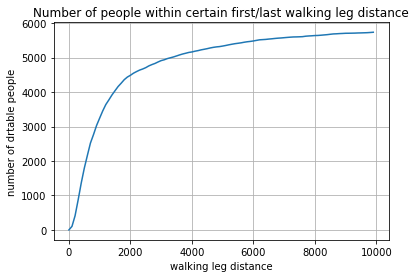

In [20]:
fig, ax = plt.subplots()
ax.plot(range(0,10000,100), x)
ax.set(xlabel='walking leg distance', ylabel='number of drtable people',
       title='Number of people within certain first/last walking leg distance')
ax.grid()

In [21]:
def trips_from_time_ratio(trips_all_outside,persons_all_outside,threshold):
    n = 0
    for tr, person in zip(trips_all_outside, persons_all_outside):
        if tr[0] is None:
            continue
            
        trip_pt = tr[0][0]
        trip_car = tr[1][0]
        
        if trip_pt.duration < trip_car.duration * threshold:
            n += 1
    return n

In [22]:
x = [trips_from_time_ratio(trips_all_outside, persons_all_outside, x) for x in np.arange(0, 10, 0.2)]

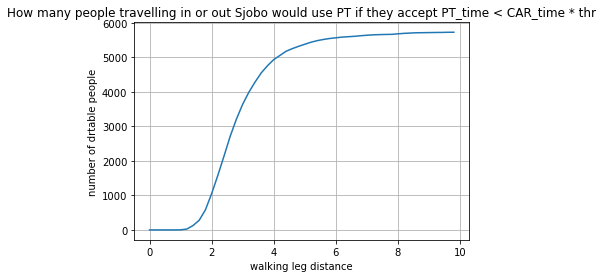

In [23]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, 10, 0.2), x)
ax.set(xlabel='walking leg distance', ylabel='number of drtable people',
       title='How many people travelling in or out Sjobo would use PT if they accept PT_time < CAR_time * thr')
ax.grid()

# With this we can calibrate time window size

In [24]:
def trips_from_time_ratio_in_out(trips_all_outside,persons_all_outside,threshold, in_zone=True):
    n = 0
    for tr, person in zip(trips_all_outside, persons_all_outside):
        if tr[0] is None:
            continue
            
        trip_pt = tr[0][0]
        trip_car = tr[1][0]
        
        szone = int(person['activities'][0]['zone'])
        if szone in sjobo and in_zone == True:
            continue
        elif szone not in sjobo and in_zone == False:
            continue
        
        if trip_pt.duration <= trip_car.duration * threshold:
            n += 1
    return n

In [25]:
pt_in = [trips_from_time_ratio_in_out(trips_all_outside, persons_all_outside, x, in_zone=True) for x in np.arange(0, 10, 0.05)]
pt_out = [trips_from_time_ratio_in_out(trips_all_outside, persons_all_outside, x, in_zone=False) for x in np.arange(0, 10, 0.05)]
print('in', pt_in)
print('out', pt_out)

in [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 6, 10, 13, 20, 30, 43, 63, 76, 102, 120, 140, 170, 204, 234, 275, 311, 350, 397, 454, 517, 556, 598, 639, 679, 724, 772, 821, 875, 919, 961, 1000, 1026, 1068, 1106, 1142, 1180, 1213, 1252, 1284, 1310, 1341, 1368, 1393, 1422, 1445, 1467, 1493, 1517, 1537, 1553, 1576, 1599, 1624, 1648, 1666, 1688, 1705, 1721, 1739, 1751, 1766, 1780, 1789, 1795, 1802, 1813, 1824, 1832, 1835, 1838, 1844, 1847, 1857, 1864, 1871, 1881, 1882, 1893, 1902, 1911, 1917, 1921, 1926, 1928, 1938, 1943, 1949, 1953, 1958, 1959, 1965, 1970, 1973, 1975, 1979, 1983, 1984, 1985, 1988, 1990, 1991, 1992, 1992, 1996, 1998, 1998, 2001, 2002, 2003, 2003, 2004, 2004, 2007, 2009, 2012, 2014, 2014, 2016, 2016, 2016, 2019, 2021, 2022, 2022, 2023, 2023, 2023, 2024, 2025, 2026, 2027, 2027, 2027, 2027, 2028, 2029, 2031, 2032, 2037, 2037, 2038, 2041, 2042, 2044, 2044, 2044, 2044, 2045, 2045, 2047, 2047, 2047, 2047, 2047, 2047, 2047, 2048, 2048, 2048, 2048, 2048, 204

In [26]:
print(pt_in[31], np.arange(0, 10, 0.05)[31])
print(pt_out[39], np.arange(0, 10, 0.05)[39])

120 1.55
520 1.9500000000000002


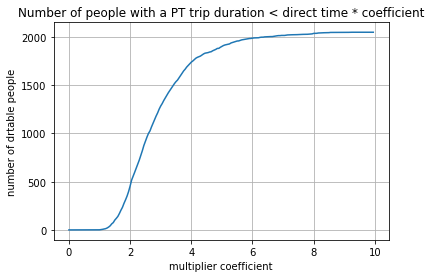

In [27]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, 10, 0.05), pt_in)
ax.set(xlabel='multiplier coefficient', ylabel='number of drtable people',
       title='Number of people with a PT trip duration < direct time * coefficient')
ax.grid()

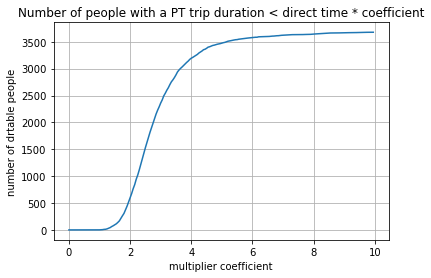

In [28]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, 10, 0.05), pt_out)
ax.set(xlabel='multiplier coefficient', ylabel='number of drtable people',
       title='Number of people with a PT trip duration < direct time * coefficient')
ax.grid()

# Redistribute people according to calibrated time windows

In [29]:
def trips_from_time_ratio(trips_all, persons_all, walk_threshold, time_coefficient, trip_in):
    pt_persons = []
    other_persons = []
    drtable_persons = []
    for tr, person in zip(trips_all, persons_all):
        
        szone = int(person['activities'][0]['zone'])
        if szone in sjobo and trip_in:
            continue
        elif szone not in sjobo and not trip_in:
            continue
        
        if tr[0] is None:
            other_persons.append(person)
            continue
        
        trip_pt = tr[0][0]
        trip_car = tr[1][0]
        
        if trip_pt.duration <= trip_car.duration * time_coefficient:
            pt_persons.append(person)
        else:
            if szone in sjobo:
                leg_dist = trip_pt.legs[-1].distance
            else:
                leg_dist = trip_pt.legs[0].distance

            if leg_dist <= walk_threshold:
                drtable_persons.append(person)
            else:
                other_persons.append(person)
    
    return pt_persons, drtable_persons, other_persons

In [30]:
pt_persons_in, drtable_persons_in, other_persons_in = \
trips_from_time_ratio(trips_all_outside, persons_all_outside, 1000, 1.55, trip_in=True)
print(len(pt_persons_in), len(drtable_persons_in), len(other_persons_in))

120 880 1065


In [31]:
pt_persons_out, drtable_persons_out, other_persons_out = \
trips_from_time_ratio(trips_all_outside, persons_all_outside, 1000, 1.95, trip_in=False)
print(len(pt_persons_out), len(drtable_persons_out), len(other_persons_out))

520 1852 1424


In [32]:
print('population_within_pt', len(pt_persons_within))
print('population_within_other', len(other_persons_within))
              
print('population_in_pt', len(pt_persons_in))
print('population_out_pt', len(pt_persons_out))
              
print('population_in_drtable', len(drtable_persons_in))
print('population_out_drtable', len(drtable_persons_out))
              
print('population_in_other', len(other_persons_in))
print('population_out_other', len(other_persons_out))

population_within_pt 86
population_within_other 2066
population_in_pt 120
population_out_pt 520
population_in_drtable 880
population_out_drtable 1852
population_in_other 1065
population_out_other 1424


In [33]:
population = {'population_within_pt': pt_persons_within, 
              'population_within_other': other_persons_within,
              
              'population_in_pt': pt_persons_in,
              'population_out_pt': pt_persons_out,
              
              'population_in_drtable': drtable_persons_in,
              'population_out_drtable': drtable_persons_out,
              
              'population_in_other': other_persons_in,
              'population_out_other': other_persons_out
             }

In [34]:
with open('data/population_VEHITS_divided_to_pt_and_others_kommun_cut_work_distr.json', 'w') as outfile:
    json.dump(population, outfile)